# Smart Plant Disease Detector

## Importing Libraries

In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import time



from PIL import Image

from sklearn.metrics import classification_report

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

## Loading Data

We Prevoiously Split the Data into Training, Validation and Testing Sets. We will now load the test data, apply the transformations and evaluate our model on it.

We will batch the data to load it into the model.

In [2]:
dir = 'PlantVillage2' + '/test'

In [3]:
transforms = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(
    224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [4]:
dataset = datasets.ImageFolder(dir, transform=transforms)

In [5]:
# Data loader
loader = torch.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=True) 

## Loading Model

In [6]:
model_checkpoint = torch.load('app/densenet121-checkpoint1.pth')

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

model.classifier = model_checkpoint['classifier']
model.load_state_dict(model_checkpoint['state_dict'])
model.class_to_idx = model_checkpoint['mapping']

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Evaluation

We will use the test data to evaluate our model.

### The metrics we will use are:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix

def get_y_pred_and_y_true(dataloader):
    """
    Get the predicted and ground truth labels from a dataloader.

    Args:
      dataloader: A PyTorch dataloader.

    Returns:
      y_pred: The predicted labels.
      y_true: The ground truth labels.
    """

    y_pred = []
    y_true = []

    batches = len(dataloader)
    for i, (images, labels) in enumerate(dataloader):

        print(f"Batch {i+1}/{batches}...", end="\r")
        log_ps = model.forward(images)
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)

        y_pred_i = top_class

        y_pred.append(y_pred_i)
        y_true.append(labels.view(*top_class.shape))

    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)

    return y_pred, y_true

y_test_pred, y_test_true = get_y_pred_and_y_true(loader)

In [8]:
# Load the npy files
y_pred = np.load('y_test_pred.npy')
y_true = np.load('y_test_true.npy')

In [9]:
target_names = {
    'Pepper__bell___Bacterial_spot': 'Pepper bell Bacterial spot',
    'Pepper__bell___healthy': 'Pepper bell healthy',
    'Potato___Early_blight': 'Potato Early blight',
    'Potato___Late_blight': 'Potato Late blight',
    'Potato___healthy': 'Potato healthy',
    'Tomato__Target_Spot': 'Tomato Target Spot',
    'Tomato_Bacterial_spot': 'Tomato Bacterial spot',
    'Tomato_Early_blight': 'Tomato Early blight',
    'Tomato_Late_blight': 'Tomato Late blight',
    'Tomato_Leaf_Mold': 'Tomato Leaf Mold',
    'Tomato_Septoria_leaf_spot': 'Tomato Septoria leaf spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite': 'Tomato Spider mites Two spotted spider mite',
}

In [10]:
class_labels = model.class_to_idx
class_labels = class_labels.keys()
class_labels = [target_names[i] for i in class_labels]
class_labels

['Pepper bell Bacterial spot',
 'Pepper bell healthy',
 'Potato Early blight',
 'Potato Late blight',
 'Potato healthy',
 'Tomato Bacterial spot',
 'Tomato Early blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Target Spot']

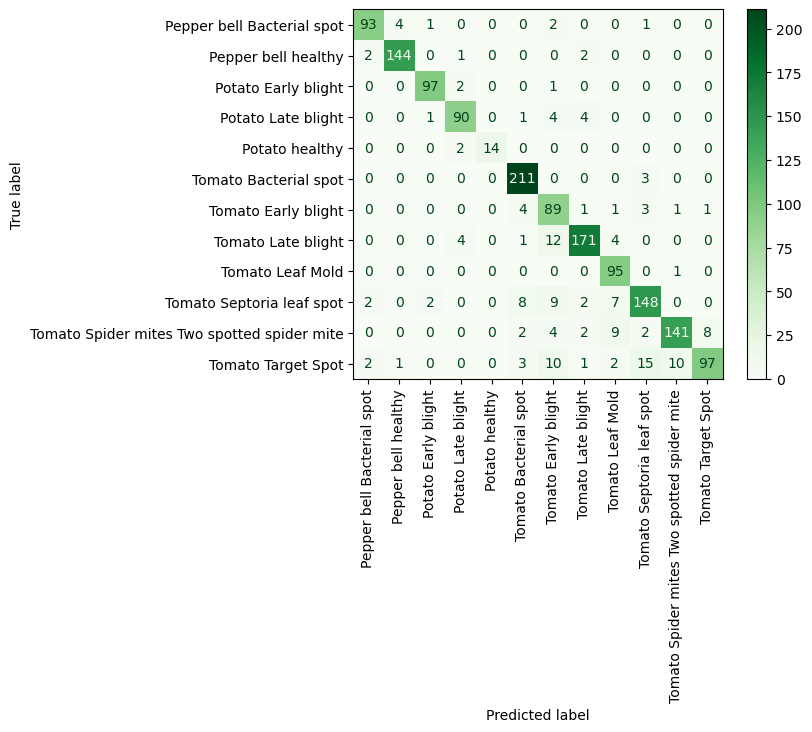

In [15]:
# Set quality of figure to be very high
plt.rcParams['savefig.dpi'] = 300

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)

# Plot the confusion matrix
disp.plot(cmap='Greens')
plt.xticks(rotation=90)
plt.show()

In [12]:
print(classification_report(y_true, y_pred, target_names=class_labels))

                                             precision    recall  f1-score   support

                 Pepper bell Bacterial spot       0.94      0.92      0.93       101
                        Pepper bell healthy       0.97      0.97      0.97       149
                        Potato Early blight       0.96      0.97      0.97       100
                         Potato Late blight       0.91      0.90      0.90       100
                             Potato healthy       1.00      0.88      0.93        16
                      Tomato Bacterial spot       0.92      0.99      0.95       214
                        Tomato Early blight       0.68      0.89      0.77       100
                         Tomato Late blight       0.93      0.89      0.91       192
                           Tomato Leaf Mold       0.81      0.99      0.89        96
                  Tomato Septoria leaf spot       0.86      0.83      0.85       178
Tomato Spider mites Two spotted spider mite       0.92      0.84

In [13]:

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    # ax = pc.axes# FOR LATEST MATPLOTLIB
    # Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    # c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle='dashed',
                  linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    # ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim((0, AUC.shape[1]))

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    # fig.set_size_inches(cm2inch(40, 20))
    # fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))


def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    # drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    figure_width = 10
    figure_height = len(class_names) + 3
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels,
            figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.show()

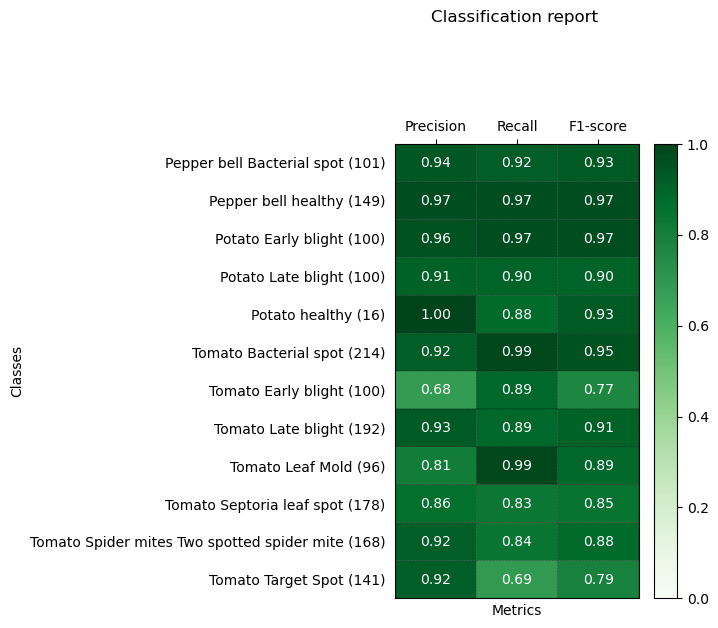

In [14]:
plot_classification_report(classification_report(
    y_true, y_pred, target_names=class_labels), number_of_classes=12, cmap='Greens')